![header](images/header.png)

# Input and general settings

<br>
<br>
<br>

The objective of this use case is to present new users the steps necessary to develop a LISFLOOD catchment model. We will guide you through the input data, the most important parts of the settings file, the diverse runs you will need to initialize the model states, and the outputs of every run.

We will suppose that there is a project in which we are asked to run a 30-year long simulation of the Nam Ngum river (Laos) to assess the water resources in the catchment.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta
from lisflood_read_plot import *

model_path = Path('../../model/')

## 1 Study area

The Nam Ngum River is a tributary of the Mekong River that flows into it a few kilometers downstream of Laos' capital city, Vientiane. The catchment has an area of approximately 16,000 km², of which 8,400 km² are regulated by the Nam Ngum Reservoir. The mean annual rainfall in the catchment is 1200 mm and a mean annual temperature around 12 °C.

The [GloFAS (Global Flood Awareness System)](https://global-flood.emergency.copernicus.eu/) streamflow dataset contains two gauging stations within the Nam Ngum River catchment. In this exercise, we will use the gauge downstream to cut the static maps and the meteorological forcing that LISFLOOD needs as input data. However, we are not interested specifically in these two gauging stations; instead, we will define three reporting points, one corresponding to the downstream gauge and two points we will locate in the tributaries of the Nam Ngum River.

![Run explanation](images/introduction_map.png)

***Figure 1**. The Nam Ngum river (Laos) is a tributary of the Mekong river.*

## 2 Input data

The input data required by the LISFLOOD model can be divided in three groups: static maps, tables and meteorological forcings.

### 2.1 Maps

They are included in the folder [_maps_], classified according to topics (_channels_, _general_, _lakes_...). This organization is voluntary, you can find your own way to organize the maps, as long as you reference them correctly in the settings file.

The specific maps for this case study were created by cutting the global maps to the catchment of our oulet gauging station. The `cutmaps` tool from the [LISFLOOD utilities repository](https://github.com/ec-jrc/lisflood-utilities) allows you to perform this task. 

LISFLOOD requires a set of maps that define catchment properties such as topography, soil properties, land use, etc. LISFLOOD users are encouraged to produce their own maps following the protocol explained [here](https://ec-jrc.github.io/lisflood-code/4_Static-Maps-introduction/). [European maps](https://data.jrc.ec.europa.eu/dataset/f572c443-7466-4adf-87aa-c0847a169f23) at 1 arcminute resolution and [global maps](https://publications.jrc.ec.europa.eu/repository/handle/JRC132801) at 3 arcminute resolution are publicly available.

#### 2.1.1 Static maps

The vast majority of these maps are static, i.e., they do not change over time. These maps include the channel properties, land cover related maps, soil properties, etc. Let's see how some of the soil properties look like:

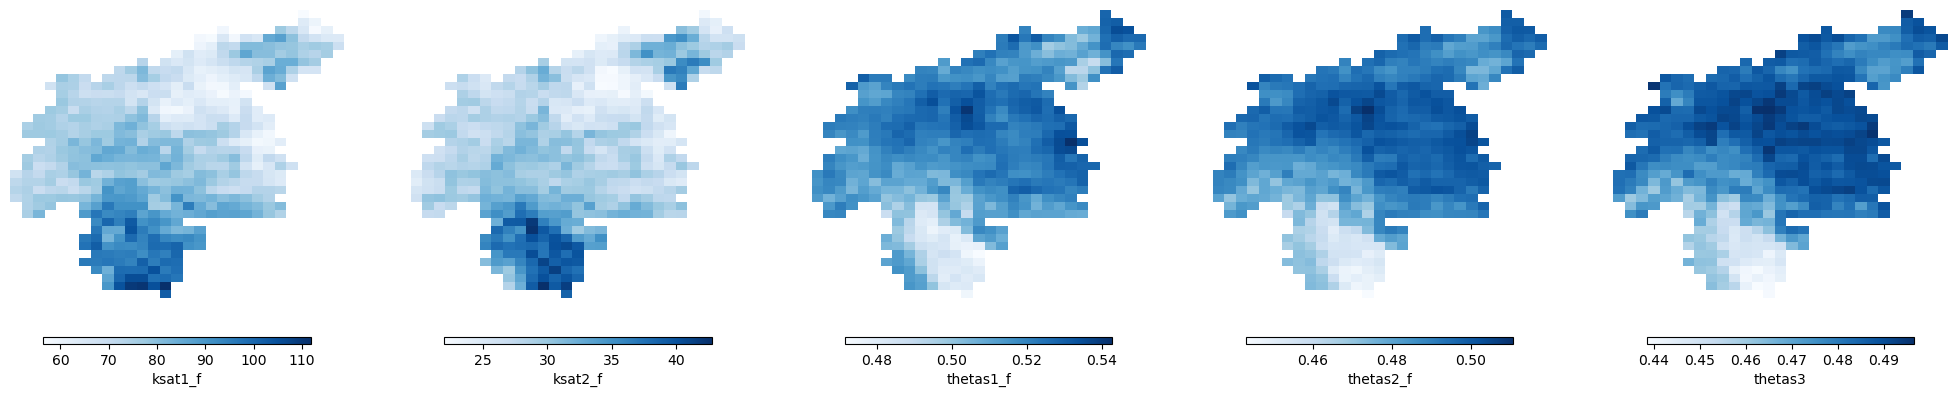

In [2]:
# load maps
variables = ['ksat1_f', 'ksat2_f', 'thetas1_f', 'thetas2_f', 'thetas3']
soils = {}
for var in variables:
    ds = xr.open_dataset(model_path / 'maps' / 'soil_hydraulics' / f'{var}.nc')
    ds.close()
    soils[var] = ds['Band1']

# plot maps
ncols = len(variables)
fig, ax = plt.subplots(ncols=ncols, figsize=(5 * ncols, 5))
for i, (var, da) in enumerate(soils.items()):
    da.plot(ax=ax[i], cmap='Blues', cbar_kwargs={'label': var, "orientation": "horizontal", "shrink": 0.8, "aspect": 40, "pad": 0.1})
    ax[i].axis('off');

***Figure 2**. Static maps of some of the soil hydraulic properties.*

> **Note**. For a detailed description of each of the input maps, including the abreviations used to identify them, please refer to this [link](https://ec-jrc.github.io/lisflood-model/4_1_annex_input-files/).

#### 2.1.2 Dynamic maps

Some of the maps, instead, are dynamic, i.e., they change over time. In our case, since we have decided to simulate land use change and water use change, there are three sets of maps with temporal evolution.

**Leaf area index (LAI)**

Leaf area index has an annual cycle, therefore, representative maps for the evolution of LAI over a generic year must be provided. LAI maps are the only compulsory dynamic maps. In this example, we provide 10-day average LAI maps (36 maps per year) for forest (_laif.nc_), irrigated (_laii.nc_) and other (_laio.nc_) land uses; you can find them in folder _maps/vegetation/_.

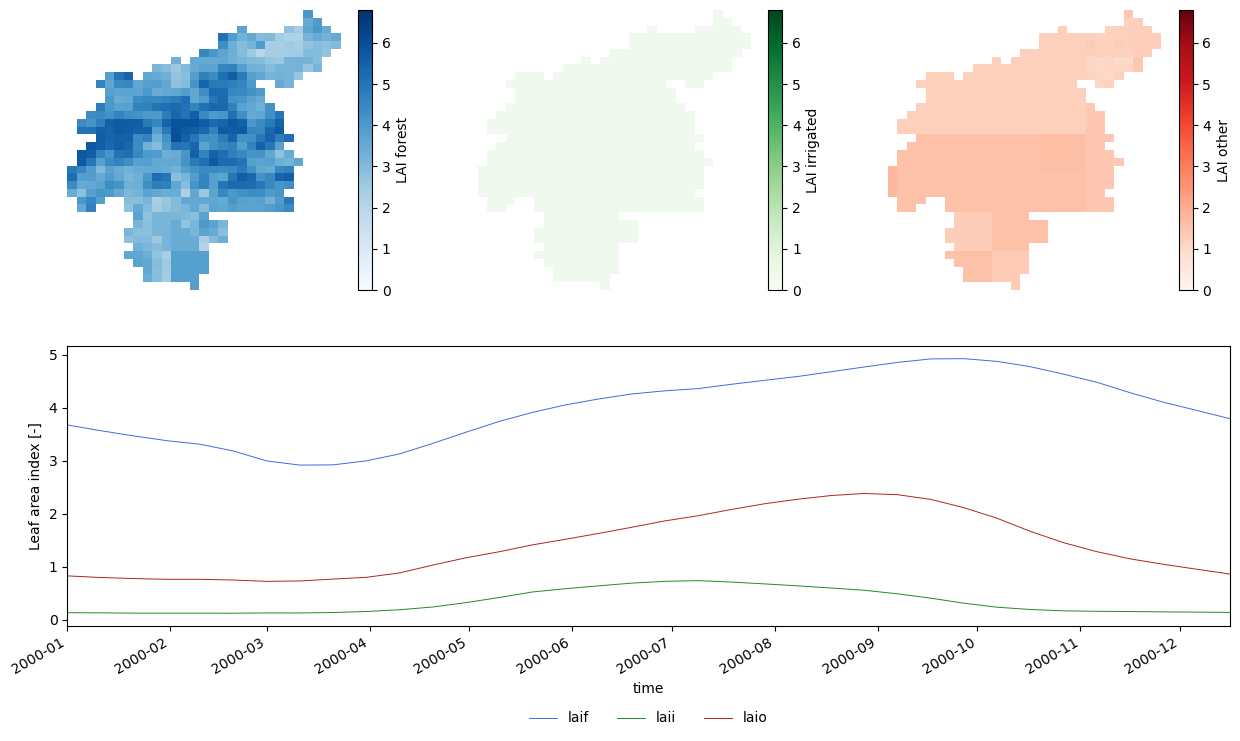

In [3]:
# load and plot some map stacks
variables = {'laif': 'LAI forest', 'laii': 'LAI irrigated', 'laio': 'LAI other'}
lai = {}
for var, name in variables.items():
    ds = xr.open_dataset(model_path / 'maps' / 'vegetation' / f'{var}.nc')
    ds.close()
    # extract the LAI variable
    da = ds['Band1']
    # set representative timesteps
    da['time'] = pd.date_range(datetime(2000, 1, 1), periods=ds.dims['time'], freq='10d')
    # set attributes
    da.name = name
    da.attrs['long_name'] = name
    da.attrs['units'] = '-'
    lai[var] = da

# plot maps and timeseries of LAI
plot_mapstacks(lai, vmin=0, vmax=6.8, ylabel='Leaf area index')

***Figure 3**. Leaf Area Index maps for different land covers. The maps on top show the mean annual LAI, whereas the lineplot at the bottom the evolution over time of the mean catchment LAI.*

> **Note**. Check this [link](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_leaf-area-index/) for more info about the use of LAI maps in LISFLOOD.

**Transient water use**

In this use case, we have decided to model the change in water use over the study period. The following plot shows how the water use is distributed spatially across the catchment and its evolution over time.

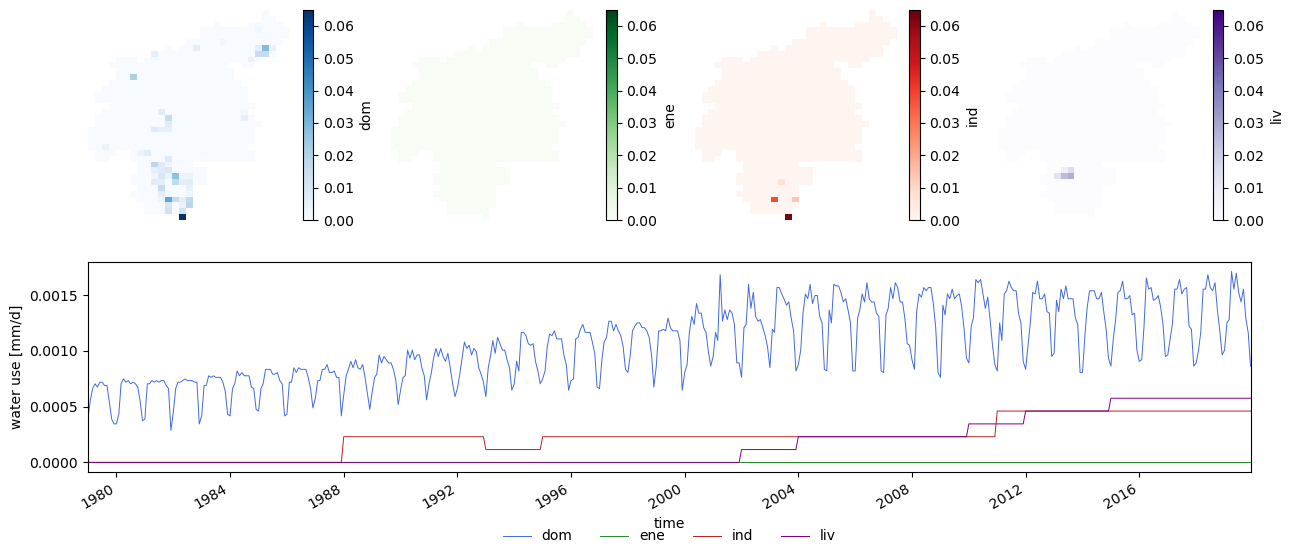

In [4]:
# load and plot some map stacks
water_use = {}
for var in ['dom', 'ene', 'ind', 'liv']:
    da = xr.open_dataarray(model_path / 'maps' / 'water_use' / f'{var}.nc')
    da.close()
    water_use[var] = da

# calculate minimum and maximum values of soil moisture among all the map stacks
vmin = np.min([da.mean('time').min() for var, da in water_use.items()])
vmax = np.max([da.mean('time').max() for var, da in water_use.items()])

plot_mapstacks(water_use, figsize=(15, 6), vmin=vmin, vmax=vmax, ylabel='water use')

***Figure 4**. Transient water use for 4 types of consumption (_dom_: domestic, _ene_: energy, _ind_: industry, _liv_: livestock). The maps on top show mean consumption over the study period, whereas the lineplot at the bottom shows the evolution over time of the mean catchment water use.*

The maps above show that water use is concentrated in a few cells over the catchment. The lineplot shows that, in our case, water use has increased in the last few decades, and that the domestic consumption has a seasonal cycle.

**Land use change**

To reproduce land use change, we provide LISFLOOD with monthly maps of the fraction of each cell devoted to each land use. The files are located in the folder _maps/land_use/dynamic_. For instance, let's see the evolution of the six land covers (forest, irrigated, other, water bodies, urban and rice) over the 41 year period:

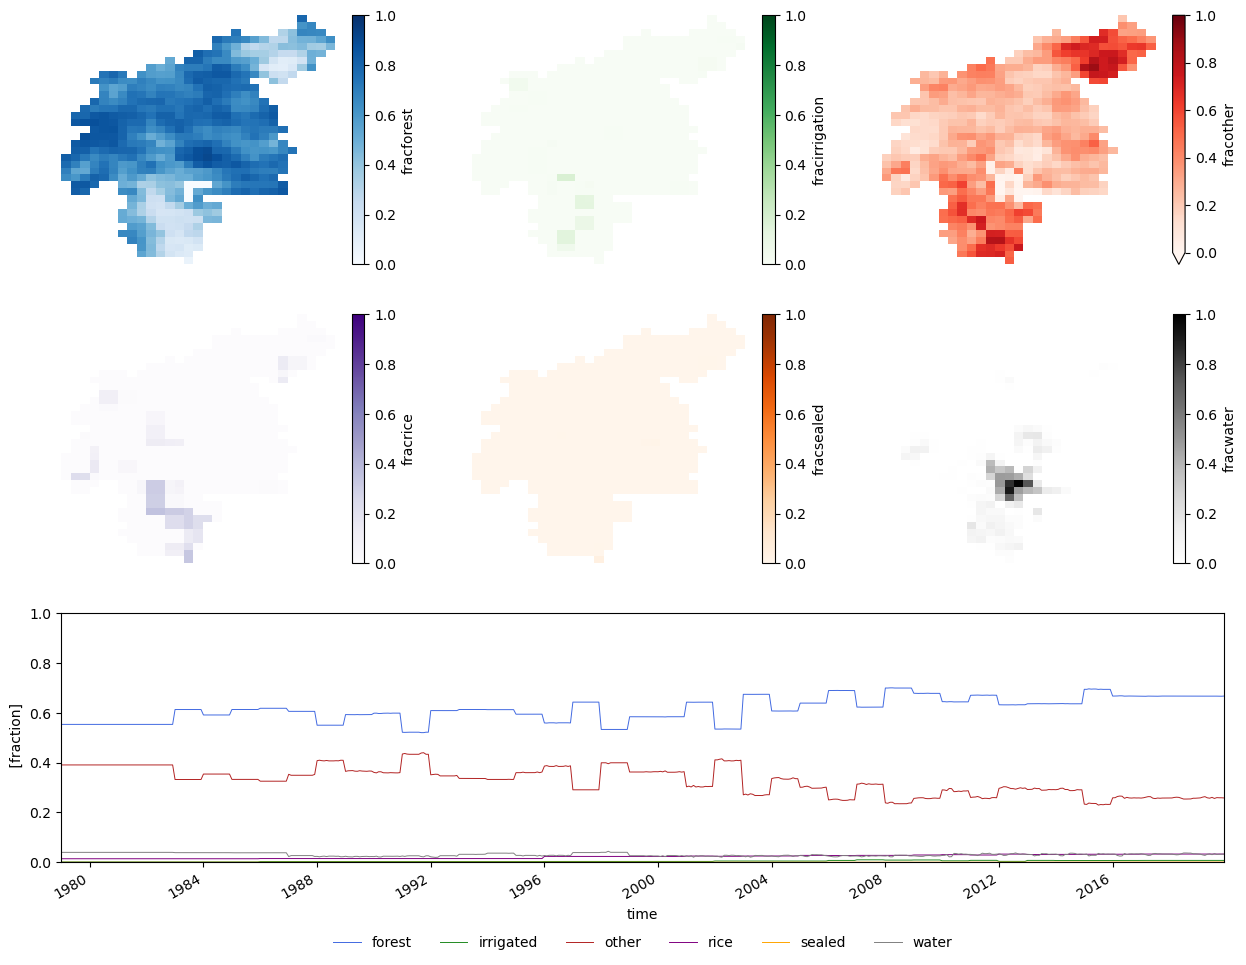

In [5]:
land_use = {}
for var in ['forest', 'irrigated', 'other', 'rice', 'sealed', 'water']:
    da = xr.open_dataarray(model_path / 'maps' / 'land_use' / 'dynamic' / f'frac{var}.nc')
    da.close()
    land_use[var] = da

plot_mapstacks(land_use, vmin=0, vmax=1, figsize=(15, 11), nrows=2, ylim=(0, 1))

***Figure 5**. Land use change. Maps represent average over time, whereas the timeseries represents average over the entire catchment.*

In our study area, the majority of the catchment belongs to either forest or the "other" fraction, with a diverging trend between the two of them. Forest cover has slightly increased, whereas the "other" fraction has decreased. The irrigated and rice cultivation areas are mostly in the lower part of the catchment, whereas the water bodies mainly refer to the reservoir. It is important to notice that the sum of all fractions must be 1.

The data provided with the use case also includes in folder _maps/land_use/static/_ the same land use fraction maps for a simulation without land use change. In that case, each file contains a unique map that applies to the whole simulation period.

> **Note**. Check this [link](https://ec-jrc.github.io/lisflood-model/3_13_optLISFLOOD_TransientLandUseChange/) for more information about the simulation of land use change in LISFLOOD.

### 2.2 Meteorological forcings

They are provided in the folder _meteo_. Five map stacks are required: air temperature 2 m above ground (_2t_), potential evaporation (_e0_), potential evaporation from bare soil (_eS0_), potential evapotranspiration (_eT0_) and precipitation (_tp_). A netCDF file is supplied for each meteorological variable; each file contains the daily maps for the 41 years of data available.

Similarly to the [maps](#2.1-Maps), the meteorological forcings were created applying the `cutmaps` tool to the global dataset developed by the GloFAS team. The use of the GloFAS meteorological dataset is not mandatory; on the contrary, we encourage users to use their preferred meteorological datasets. The only requirement is that the meteorological forcings must match the spatial definition (coordinate reference system, resolution and grid) of the static maps. The repository [`pyg2p`](https://github.com/ec-jrc/pyg2p) developed by the LISFLOOD team can be useful for these tasks.

Let's inspect one of these files, e.g., the air temperature.

Data dimensions: Frozen({'lon': 29, 'lat': 36, 'time': 14975})


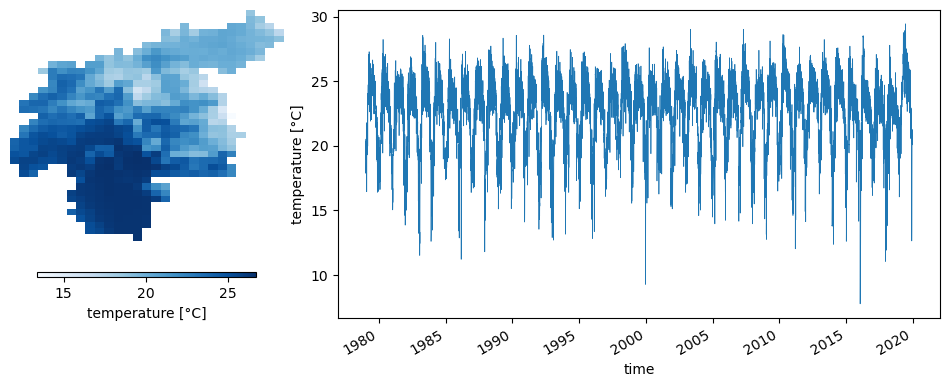

In [7]:
# load the temperature stack map
T = xr.open_dataset(model_path / 'meteo' / '2t.nc')

# check the dimensions of the data
print('Data dimensions: {0}'.format(T.dims))

# extract the temperature variable
t = T['2t']
t.data[t.data == 0] = np.nan

# create a simple plot of the data
plot_map_timeseries(t, lw=.5, label='temperature [°C]', cmap='Blues')

T.close()

***Figure 6**. Air temperature. On the left, a map of the mean temperature; on the right, a time series of mean areal temperature.*

> **Exercise**. Try to inspect the other meteorological datasets.

### 2.3 Tables

LISFLOOD uses tables (TXT files) to provide specific parameters for the lake and reservoir simulation. In this use case, since there are no lakes in the catchment, we only require these text files for the reservoir simulation (see folder _tables/reservoirs_). Each of the TXT files is a two-entry table; the first column represents the reservoir ID and the second column the value of the corresponding variable.

As an example, the following code snippet corresponds to the file _rnormq.txt_, which defines the normal reservoir outflow (159.1 m³/s) for the Nam Ngum Reservoir (which in the GloFAS dataset has ID 530).

```txt
530 159.1
```

The location of the reservoir is defined a static map (_maps/reservoirs/reservoirs.nc_), that only contains values representing the reservoir ID at the dam locations. In our case, this map contains only one value (530) that defines the location of our reservoir.

## 3 General setup

### 3.1 Runs

As mentioned above, the objective of this use case is to have a climatology of river discharge in three points of the Nam Ngum River. To do so, a simulation of 30 years needs to be done. Before we proceed with the run, we must both initialize the LISFLOOD model of the catchment and warmup the state variables. In total, we will simulate three runs:

* An **initialization run** to estimate the average discharge in the river network (required by the kinematic wave split routing) and the average inflow in the lower groundwater zone (required to estimate the initial conditions of the lower groundwater zone). Please, read this [link](https://ec-jrc.github.io/lisflood-code/3_step5_model-initialisation/) for further information on LISFLOOD initialization.
* A **warm-up run** to estimate the state variables at the beginning of the period of interest. This run is not mandatory for a simulation like ours. It is done here only to show how the end states of a simulation can be applied as the initial conditions of a succeeding simulation. A simpler and more common approach is to simulate the main run with default initial conditions and to discard the first few years of the results, assuming that the results at the beginning of the simulation are not reliable due to unrealistic initial conditions.
* The actual **30-year run**.

The following figure shows the extent of these three simulations in our case study. The meteorological data spans from 01-01-1979 to 31-12-2019, so 41 years of data are available. It is recommended that the initialization run be as long as possible; therefore, the 41 years of data are used for this run. To warm up the model we use the first 11 years of data (1979-1990) and the remaining 30 years are used for the actual run.

![Run explanation](images/3_run_explanation.png)

***Figure 7**. Time periods of the three runs. The initialization run expands the complete 41 years of meteorological data. This period is divided in a warmup run (11 first years) and the actual run (30 years).*

### 3.2 General settings

The Nam Ngum river catchment has a set of particularities for which it was chosen as a use case.

* There is a reservoir that regulates approximately half of the catchment.
* There is an extensive area of the catchment dedicated to rice production.
* We want to include in the simulation the change over time of both water demand and land use.
* We want to apply split kinematic wave routing.
* The maps are in a geographic coordinate system (latitude and longitude), so we must input maps for pixel length and area (activation via option `gridSizeUserDefined` in the settings file).

With all these requirements, we can start working from the [default settings file](https://github.com/ec-jrc/lisflood-code/blob/master/src/lisfloodSettings_reference.xml) and define our specific settings.

#### 3.2.1 Model options

These are the LISFLOOD modules activated in the `<lfoptions>` element of the settings file:

```xml
<lfoptions>

    # [...]
    
    <setoption choice="1" name="gridSizeUserDefined"/>

    # option to read/write NetCDF
    <setoption choice="1" name="readNetcdfStack"/>
    <setoption choice="1" name="writeNetcdfStack"/>
    <setoption choice="1" name="writeNetcdf"/>

    # options to turn hydrological modules on/off
    <setoption choice="1" name="wateruse"/>
    <setoption choice="1" name="TransientWaterDemandChange"/>
    <setoption choice="1" name="TransientLandUseChange"/>
    <setoption choice="1" name="wateruseRegion"/>
    <setoption choice="1" name="drainedIrrigation"/>
    <setoption choice="1" name="riceIrrigation"/>
    <setoption choice="1" name="openwaterevapo"/>
    <setoption choice="1" name="simulateReservoirs"/>
    <setoption choice="1" name="SplitRouting"/>

    # [...]

</lfoptions>
```

These options apply to the three runs (*settings_initialization.xml*, *settings_warmup.xml* and *settings_run.xml*). As we will see in the following notebooks, other options will change depending on the run.

#### 3.2.2 Calibration parameters

Among the multiple model parameters in LISFLOOD, the recommended calibration procedure focuses on tuning a smaller set of parameters. These calibration parameters can be found in the settings file within the element `<lfusers>`; the comments on each of these paremeters show their default value. We will start running our catchment model with these default values.

```xml
<textvar name="UpperZoneTimeConstant" value="10"/>
<textvar name="LowerZoneTimeConstant" value="100"/>
<textvar name="GwPercValue" value="0.5"/>
<textvar name="GwLoss" value="0"/>
<textvar name="LZThreshold" value="$(PathSoilHyd)/lzthreshold_Global_03min.nc"/>
<textvar name="b_Xinanjiang" value="0.7"/>
<textvar name="PowerPrefFlow" value="3.5"/>
<textvar name="CalChanMan" value="2.0"/>
<textvar name="CalChanMan2" value="3.0"/>
<textvar name="SnowMeltCoef" value="4"/>
<textvar name="LakeMultiplier" value="1"/>
<textvar name="adjust_Normal_Flood" value="0.8"/>
<textvar name="ReservoirRnormqMult" value="1.0"/>
<textvar name="QSplitMult" value="2"/>
```

> **Note**. Bear in mind that the default parameter values are simply a way to start the model, but they should be calibrated against observations in your specific catchment. The [LISFLOOD-calibration repository](https://github.com/ec-jrc/lisflood-calibration) is a possible way of calibrating your model, but you can use any other procedure.